In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize

In [2]:
def cvt_local2global(local_point, sc_point):
    x, y, a = local_point.T
    X, Y, A = sc_point.T
    x1 = x * np.cos(A) - y * np.sin(A) + X
    y1 = x * np.sin(A) + y * np.cos(A) + Y
    a1 = (a + A) % (2 * np.pi)
    return np.array([x1, y1, a1]).T


def cvt_global2local(global_point, sc_point):
    x, y, a = global_point.T
    X, Y, A = sc_point.T
    x1 = x * np.cos(A) + y * np.sin(A) - X * np.cos(A) - Y * np.sin(A)
    y1 = -x * np.sin(A) + y * np.cos(A) + X * np.sin(A) - Y * np.cos(A)
    a1 = (a - A) % (2 * np.pi)
    return np.array([x1, y1, a1]).T

def find_src(global_point, local_point):
    x, y, a = local_point.T
    x1, y1, a1 = global_point.T
    A = (a1 - a) % (2 * np.pi)
    X = x1 - x * np.cos(A) + y * np.sin(A)
    Y = y1 - x * np.sin(A) - y * np.cos(A)
    return np.array([X, Y, A]).T

In [379]:
# Dimensions of the playing field
WORLD_X = 3000
WORLD_Y = 2000
WORLD_BORDER = 22
BEAC_R = 96.0 / 2
BEAC_L = 100.0
BEAC_BORDER = 22.0

ORANGE_BEACONS = np.array([[WORLD_X + WORLD_BORDER + BEAC_BORDER + BEAC_L / 2., WORLD_Y / 2.],
                           [-(WORLD_BORDER + BEAC_BORDER + BEAC_L / 2.), WORLD_Y - BEAC_L / 2.],
                           [-(WORLD_BORDER + BEAC_BORDER + BEAC_L / 2.), BEAC_L / 2.]])

GREEN_BEACONS = np.array([[-(WORLD_BORDER + BEAC_BORDER + BEAC_L / 2.), WORLD_Y / 2.],
                          [WORLD_X + WORLD_BORDER + BEAC_BORDER + BEAC_L / 2., WORLD_Y - BEAC_L / 2.],
                          [WORLD_X + WORLD_BORDER + BEAC_BORDER + BEAC_L / 2., BEAC_L / 2.]])

# parameters of lidar
LIDAR_DELTA_ANGLE = (np.pi / 180) / 4
LIDAR_START_ANGLE = -(np.pi / 2 + np.pi / 4)


class ParticleFilter:
    def __init__(self, particles_num=500, sense_noise=50, distance_noise=5, angle_noise=0.02, start_x=293, start_y=425,
                 start_angle=3 * np.pi / 2, color='orange', min_intens=3500.0, max_dist=3700.0,
                 k_angle=4, beac_dist_thresh=300, num_is_near_thresh=0.1, dist_offset=0):

        self.start_coords = np.array([start_x, start_y, start_angle])
        self.color = color
        if color == 'orange':
            self.beacons = ORANGE_BEACONS
        else:
            self.beacons = GREEN_BEACONS

        self.last = (start_x, start_y, start_angle)
        
        self.particles_num = particles_num
        self.sense_noise = sense_noise
        self.distance_noise = distance_noise
        self.angle_noise = angle_noise
        self.min_intens = min_intens
        self.max_dist = max_dist
        self.k_angle = k_angle
        self.beac_dist_thresh = beac_dist_thresh
        self.num_is_near_thresh = num_is_near_thresh
        self.dist_offset = dist_offset
        self.num_seeing_beacons = 3

        # Create Particles
        x = np.random.normal(start_x, distance_noise, particles_num)
        y = np.random.normal(start_y, distance_noise, particles_num)
        angle = np.random.normal(start_angle, angle_noise, particles_num) % (2 * np.pi)
        self.particles = np.array([x, y, angle]).T
        self.landmarks = [[], []]
        
        self.min_cost_function = 0

    @staticmethod
    def gaus(x, mu=0, sigma=1):
        """calculates the probability of x for 1-dim Gaussian with mean mu and var. sigma"""
        return np.exp(- ((x - mu) ** 2) / (sigma ** 2) / 2.0) / np.sqrt(2.0 * np.pi * (sigma ** 2))

    @staticmethod
    def p_trans(a, d):
        x_beac = d * np.cos(a)
        y_beac = d * np.sin(a)
        return x_beac, y_beac
    
    def localisation(self, delta_coords, lidar_data):
        self.move_particles([delta_coords[0], delta_coords[1], delta_coords[2]])
        self.particles = self.particle_sense(lidar_data, self.particles)
        main_robot = self.calculate_main()
        return main_robot

    def particle_sense(self, scan, particles):
        angle, distance = self.get_landmarks(scan, self.min_intens)
        x_coords, y_coords = self.p_trans(angle, distance)
        self.landmarks = np.array([x_coords, y_coords]).T
        weights = self.weights(self.landmarks, particles)
        inds = self.resample(weights)
        self.min_cost_function = np.mean(self.cost_function)
        particles = particles[inds, :]
        return particles
    
    def move_particles(self, delta):  # delta = [dx,dy,d_rot]
        if self.num_seeing_beacons in [2, 3]:
            d_n = self.distance_noise
            a_n = self.angle_noise
        elif self.num_seeing_beacons == 1:
            d_n = self.distance_noise / 10
            a_n = self.angle_noise / 2
        else:
            a_n = self.angle_noise
            d_n = self.distance_noise
#         d_n = self.distance_noise
#         a_n = self.angle_noise
        x_noise = np.random.normal(0, d_n, self.particles_num)
        y_noise = np.random.normal(0, d_n, self.particles_num)
        angle_noise = np.random.normal(0, a_n, self.particles_num)
        noise = np.array([x_noise, y_noise, angle_noise]).T
        move_point = delta + noise
        self.particles = cvt_local2global(move_point, self.particles)

    def resample(self, weights):
        """ according to weights """
        n = self.particles_num
        weigths = np.array(weights)
        indices = []
        C = np.append([0.], np.cumsum(weigths))
        j = 0
        u0 = (np.random.rand() + np.arange(n)) / n
        for u in u0:
            while j < len(C) and u > C[j]:
                j += 1
            indices += [j - 1]
        return indices

    def calculate_main(self):
        x = np.mean(self.particles[:, 0])
        y = np.mean(self.particles[:, 1])
        zero_elem = self.particles[0, 2]
        # this helps if particles angles are close to 0 or 2*pi
        temporary = ((self.particles[:, 2] - zero_elem + np.pi) % (2.0 * np.pi)) + zero_elem - np.pi
        angle = np.mean(temporary) % (2.0 * np.pi)
        return np.array((x, y, angle))

    def weights(self, landmarks, particles):
        """Calculate particle weights based on their pose and landmards"""
        # determines 3 beacon positions (x,y) for every particle in it's local coords
        res = self.beacons[np.newaxis, :, :] - particles[:, np.newaxis, :2]
        X = (res[:, :, 0] * np.cos(particles[:, 2])[:, np.newaxis]
             + res[:, :, 1] * np.sin(particles[:, 2])[:, np.newaxis])
        Y = (-res[:, :, 0] * np.sin(particles[:, 2])[:, np.newaxis]
             + res[:, :, 1] * np.cos(particles[:, 2])[:, np.newaxis])
        beacons = np.concatenate((X[:, :, np.newaxis], Y[:, :, np.newaxis]), axis=2)
        
        # find closest beacons to landmark
        dist_from_beacon = np.linalg.norm(beacons[:, np.newaxis, :, :] -
                                          landmarks[np.newaxis, :, np.newaxis, :], axis=3)
        ind_closest_beacon = np.argmin(dist_from_beacon, axis=2)
        closest_beacons = beacons[np.arange(beacons.shape[0])[:, np.newaxis], ind_closest_beacon]
        
        # Calculate cos of angle between landmark, beacon and particle
        scalar_product = np.sum((closest_beacons - particles[:, np.newaxis, :2]) *
                                (closest_beacons - landmarks[np.newaxis, :, :2]), axis=2)
        dist_from_closest_beacon_to_particle = np.linalg.norm(closest_beacons - particles[:, np.newaxis, :2], axis=2)
        dist_from_closest_beacon_to_landmark = np.linalg.norm(closest_beacons - landmarks[np.newaxis, :, :2], axis=2) 
        cos_landmarks = scalar_product /\
                        np.where(dist_from_closest_beacon_to_landmark, dist_from_closest_beacon_to_landmark, 1) /\
                        np.where(dist_from_closest_beacon_to_particle, dist_from_closest_beacon_to_particle, 1)
        
        # Calculate errors of position of landmarks
        errors = np.abs(dist_from_closest_beacon_to_landmark - BEAC_R) ** 2 +\
                 self.k_angle * np.abs(1 - cos_landmarks) ** 2

        # too far real beacons go away: non valid
        is_near = dist_from_closest_beacon_to_landmark < self.beac_dist_thresh
        is_near_sum = np.sum(is_near, axis=0)
        is_near_or = (is_near_sum > is_near.shape[0] * self.num_is_near_thresh)
        self.is_near_or = is_near_or
        num_good_landmarks = np.sum(is_near_or)
        sum_errors = np.sum(errors * is_near_or[np.newaxis, :], axis=1)
            
        max_good_landmark = np.max(num_good_landmarks)
        if num_good_landmarks:
            self.cost_function = np.sqrt(sum_errors) / num_good_landmarks
        else:
            self.cost_function = np.ones(sum_errors.shape[0]) * 1000
        
        is_beacon_seeing = np.ones(3) * False
        for i in range(3):
            is_beacon_seeing[i] = np.any(i == ind_closest_beacon[:, is_near_or])
        self.num_seeing_beacons = np.sum(is_beacon_seeing)
    
        weights = self.gaus(self.cost_function, mu=0, sigma=self.sense_noise)
        if np.sum(weights) > 0:
            weights /= np.sum(weights)
        else:
            weights = np.ones(particles.shape[0], dtype=np.float) / particles.shape[0]
            
        self.best_particles = {}
        self.particles1 = self.particles.copy()
        self.weights1 = weights.copy()
        best_particles_inds = np.argsort(self.cost_function)[:10]
        self.best_particles["particles"] = particles[best_particles_inds]
        self.best_particles["cost_function"] = self.cost_function[best_particles_inds]
        self.best_particles["num_good_landmarks"] = num_good_landmarks# [best_particles_inds]
        self.best_particles["weights"] = weights[best_particles_inds]
        self.is_beacon_seeing = is_beacon_seeing
        return weights
    
    def get_landmarks(self, scan, min_intens):
        """Returns filtrated lidar data"""
        ind = np.where(np.logical_and(scan[:, 1] > min_intens, scan[:, 0] < self.max_dist))[0]
        angles = (LIDAR_DELTA_ANGLE * ind + LIDAR_START_ANGLE) % (2 * np.pi)
        distances = scan[ind, 0]
#         self.intens = np.sqrt(scan[ind, 1])
        return angles, distances - self.dist_offset

In [267]:
START_POINTS = np.array([[735, 1080, 1.57],
                         [280, 525, 4.71],
                         [600, 950, 4.71],
                         [760, 1012, 4.71],
                         [754, 690, 4.71],
                         [120, 525, 4.71],
                         [800, 1400, 3.14],
                         [170, 1730, 5.50],
                         [610, 1835, 3.14],
                         [2175, 570, 2.45],
                         [2090, 510, 4.71],
                         [0, 0, 0],
                         [2180, 590, 3.30],
                         [1486, 893, 0.2],
                         [767, 944, 1]])

LIDAR_POINTS = np.array([[0, 60, 1.57],
                         [-25, 36, 1.63],
                         [-25, 36, 1.63],
                         [-25, 36, 1.63],
                         [-25, 36, 1.63],
                         [-25, 36, 1.63],
                         [-25, 36, 1.63],
                         [-25, 36, 1.63],
                         [-25, 36, 1.63],
                         [0, 60, 1.57],
                         [0, 60, 1.57],
                         [0, 0, 0],
                         [-25, 36, 1.63],
                         [0, 60, 1.57],
                         [0, 60, 1.57],
                         [0, 60, 1.57]])
COLORS = ["orange",
          "orange",
          "orange",
          "orange",
          "orange",
          "orange",
          "orange",
          "orange",
          "orange",
          "green",
          "green",
          "green",
          "green",
          "green",
          "green",
          "green",
          "green"]

In [268]:
k = 10
start_point = START_POINTS[k - 1]
lidar_point = LIDAR_POINTS[k - 1]
start_lidar_point = cvt_local2global(lidar_point, start_point)

In [269]:
pf = ParticleFilter(color=COLORS[k], start_x=start_lidar_point[0], start_y=start_lidar_point[1], 
                    start_angle=start_lidar_point[2])

# Read data

In [7]:
scans = np.load("laser_scans%d.npy"%k)
N = scans.shape[0]

(-200, 2200)

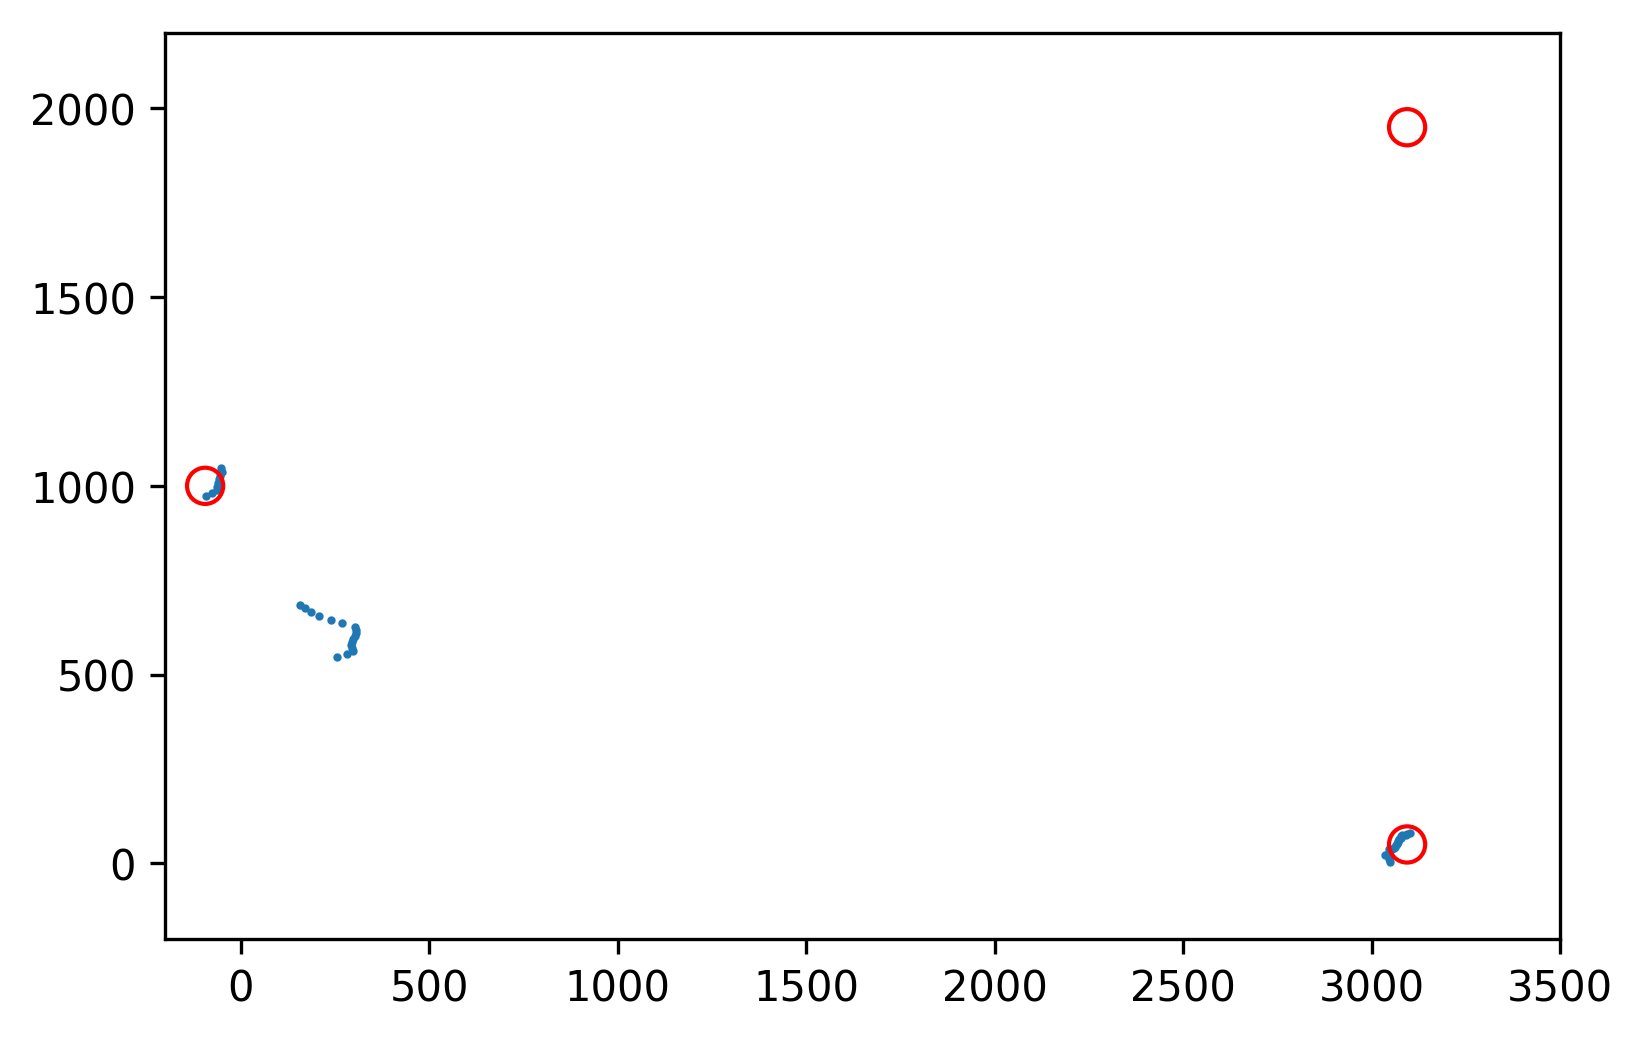

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)

for i in range(0, 1):
    x, y = pf.p_trans(*pf.get_landmarks(scans[i], pf.min_intens))
    points = np.zeros((len(x), 3))
    points[:, 0] = x
    points[:, 1] = y
    ax.scatter(*cvt_local2global(points, start_lidar_point)[:, 0:2].T,  s=1)
    
for b in pf.beacons:
    ax.add_artist(plt.Circle(b, BEAC_R, linewidth=1, fill=False, color="r"))
plt.xlim(-200, 3500)
plt.ylim(-200, 2200)

# Get odometry movement

In [10]:
raw_odom_coords = np.load("odom_coords%d.npy"%k)
raw_odom_coords[:, :2] *= 1000

In [11]:
odom_diff = cvt_global2local(raw_odom_coords, raw_odom_coords[0])
odom_robot_points = cvt_local2global(odom_diff, start_point)
odom_lidar_points = cvt_local2global(lidar_point, odom_robot_points)

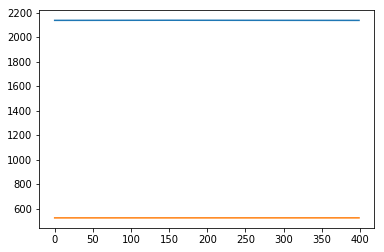

In [12]:
plt.plot(odom_lidar_points[:, 0])
plt.plot(odom_lidar_points[:, 1])

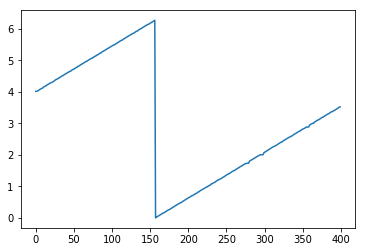

In [13]:
plt.plot(odom_lidar_points[:, 2])

## Laser scans in odom frames

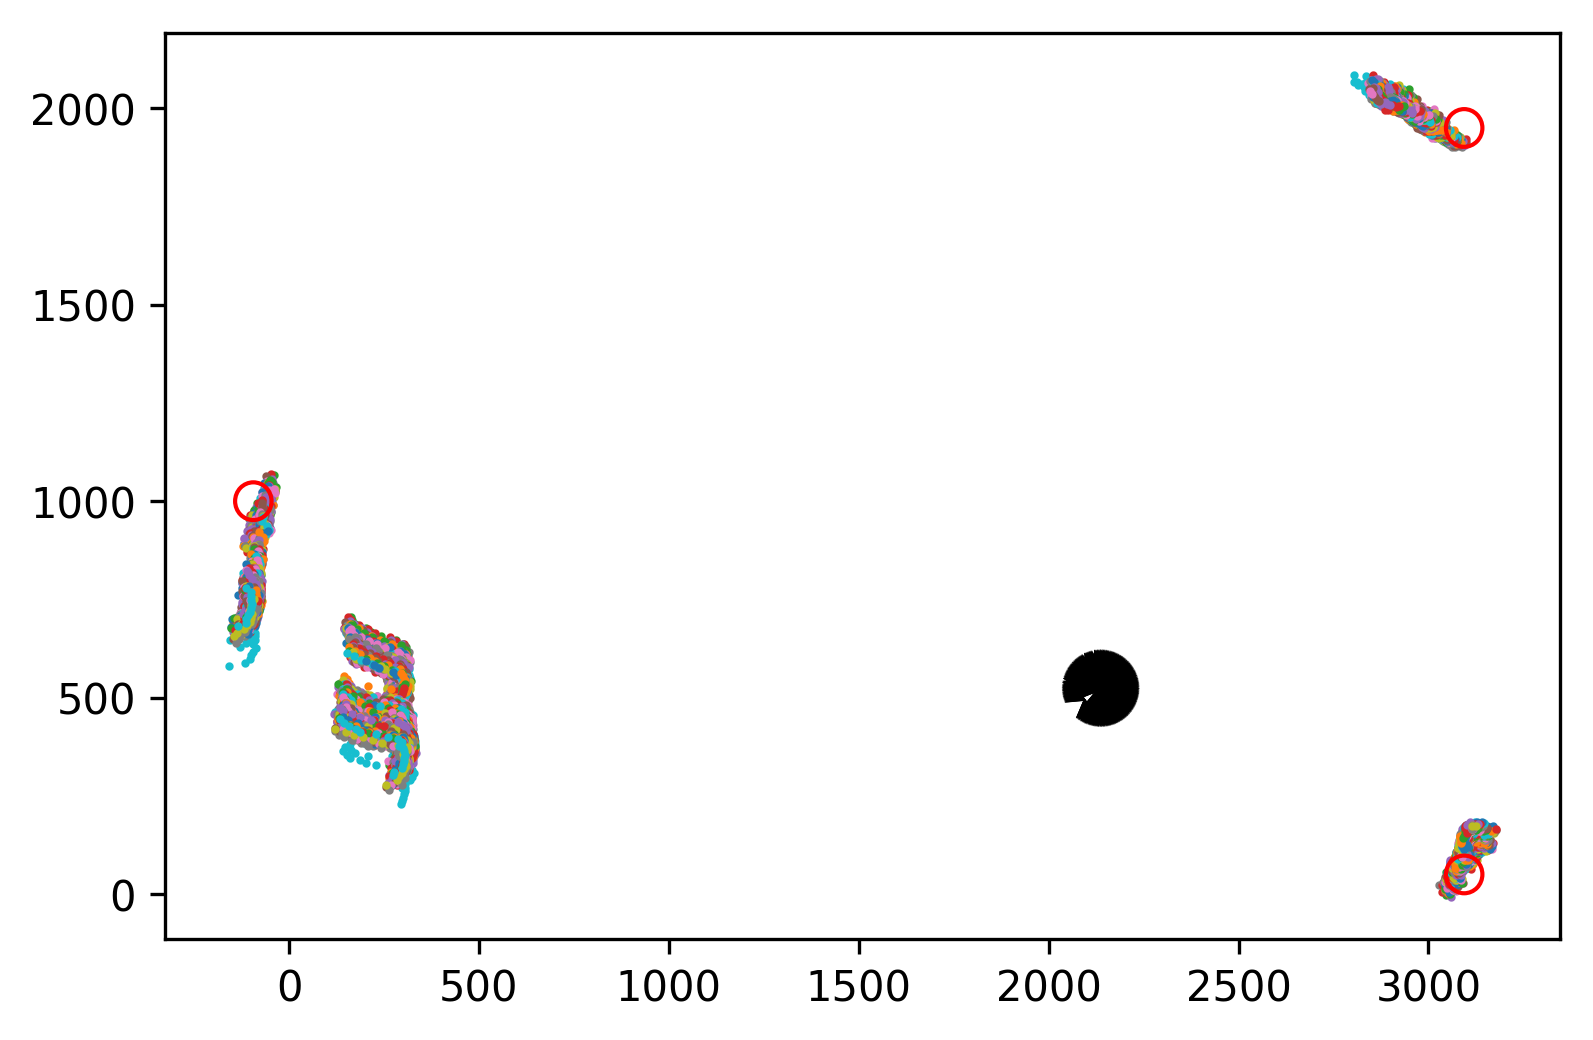

In [14]:
ind_start, ind_end = 0, N
ps = odom_lidar_points[ind_start:ind_end]
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)

for i in range(ind_start, ind_end):
    x, y = pf.p_trans(*pf.get_landmarks(scans[i], pf.min_intens))
    points = np.zeros((len(x), 3))
    points[:, 0] = x
    points[:, 1] = y
    ax.scatter(*cvt_local2global(points, odom_lidar_points[i])[:, 0:2].T,  s=1)
    
for b in pf.beacons:
    ax.add_artist(plt.Circle(b, BEAC_R, linewidth=1, fill=False, color="r"))
    
ax.quiver(ps[:, 0], ps[:, 1], np.cos(ps[:, 2]), np.sin(ps[:, 2]))
# plt.xlim(-200, 3200)
# plt.ylim(-200, 2200)

## Delta coords

In [309]:
delta_coords = cvt_global2local(odom_lidar_points, np.roll(odom_lidar_points, 1, axis=0))
delta_coords[0] = np.array([0, 0, 0])
delta_coords[-1] = np.array([0, 0, 0])

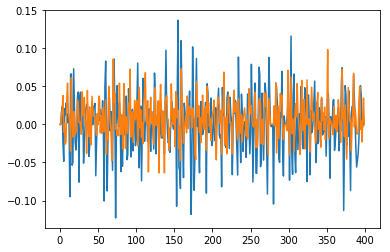

In [310]:
plt.plot(delta_coords[:, 0])
plt.plot(delta_coords[:, 1])

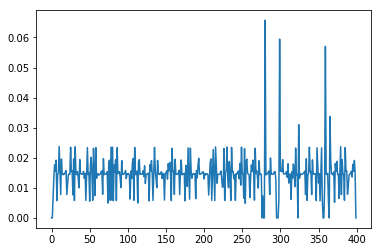

In [311]:
plt.plot(np.where(delta_coords[:, 2] < np.pi, delta_coords[:, 2], -2 * np.pi + delta_coords[:, 2]))

# Try PF

In [380]:
# sense_noise = 10
# distance_noise = 1
# angle_noise = 0.15
# max_itens=3000
# back_side_cost=10

In [381]:
PF_PARAMS = {"particles_num": 1000,
             "sense_noise": 0.5,
             "distance_noise": 8,
             "angle_noise": 0.1,
             "min_intens": 3000,
             "max_dist": 3700,
             "k_angle": 100,
             "beac_dist_thresh": 150,
             "num_is_near_thresh": 0.1,
             "dist_offset": 0}

In [382]:
%%time
pf = ParticleFilter(color=COLORS[k], start_x=start_lidar_point[0], start_y=start_lidar_point[1], 
                    start_angle=start_lidar_point[2], **PF_PARAMS)
pf_points = []
cost_functions = []
all_particles = []
best_particles_information = []
all_particles1 = []
all_weights = []
all_is_near = []
all_is_beacon_seeing = []
for i in range(N):
    pf_points.append(pf.localisation(delta_coords[i], scans[i]))
    best_particles_information.append(pf.best_particles)
    cost_functions.append(pf.min_cost_function)
    all_particles.append(pf.particles.copy())
    all_particles1.append(pf.particles1.copy())
    all_weights.append(pf.weights1)
    all_is_near.append(pf.is_near_or)
    all_is_beacon_seeing.append(pf.is_beacon_seeing)
all_particles1 = np.array(all_particles1)
all_weights = np.array(all_weights)
pf_points = np.array(pf_points)
all_particles = np.array(all_particles)
all_is_near = np.array(all_is_near)
all_is_beacon_seeing = np.array(all_is_beacon_seeing)

CPU times: user 3.92 s, sys: 0 ns, total: 3.92 s
Wall time: 3.92 s


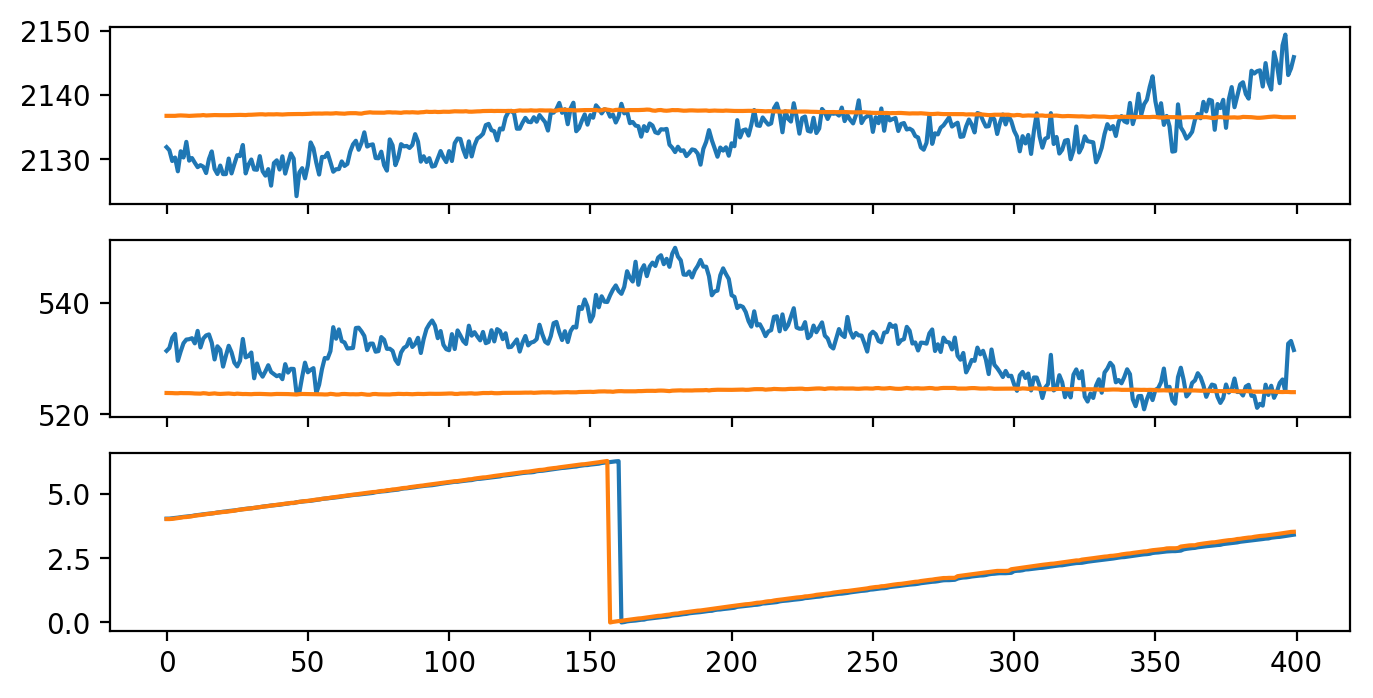

In [383]:
fig, ax = plt.subplots(3, 1, figsize=(8, 4), dpi=200, sharex=True)
for i in range(3):
    ax[i].plot(pf_points[:, i])
    ax[i].plot(odom_lidar_points[:, i])

In [369]:
# pf_points1 = np.ones(pf_points.shape[0])[:, np.newaxis] * np.array([789, 1012, 0.04])[np.newaxis, :]
# np.save("pf_true_points%d.npy"%k, pf_points)

7243.037182957549


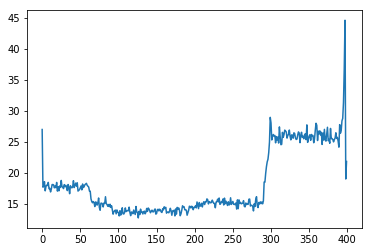

In [317]:
plt.plot(cost_functions)
print(np.sum(cost_functions[:]))

(-200, 2200)

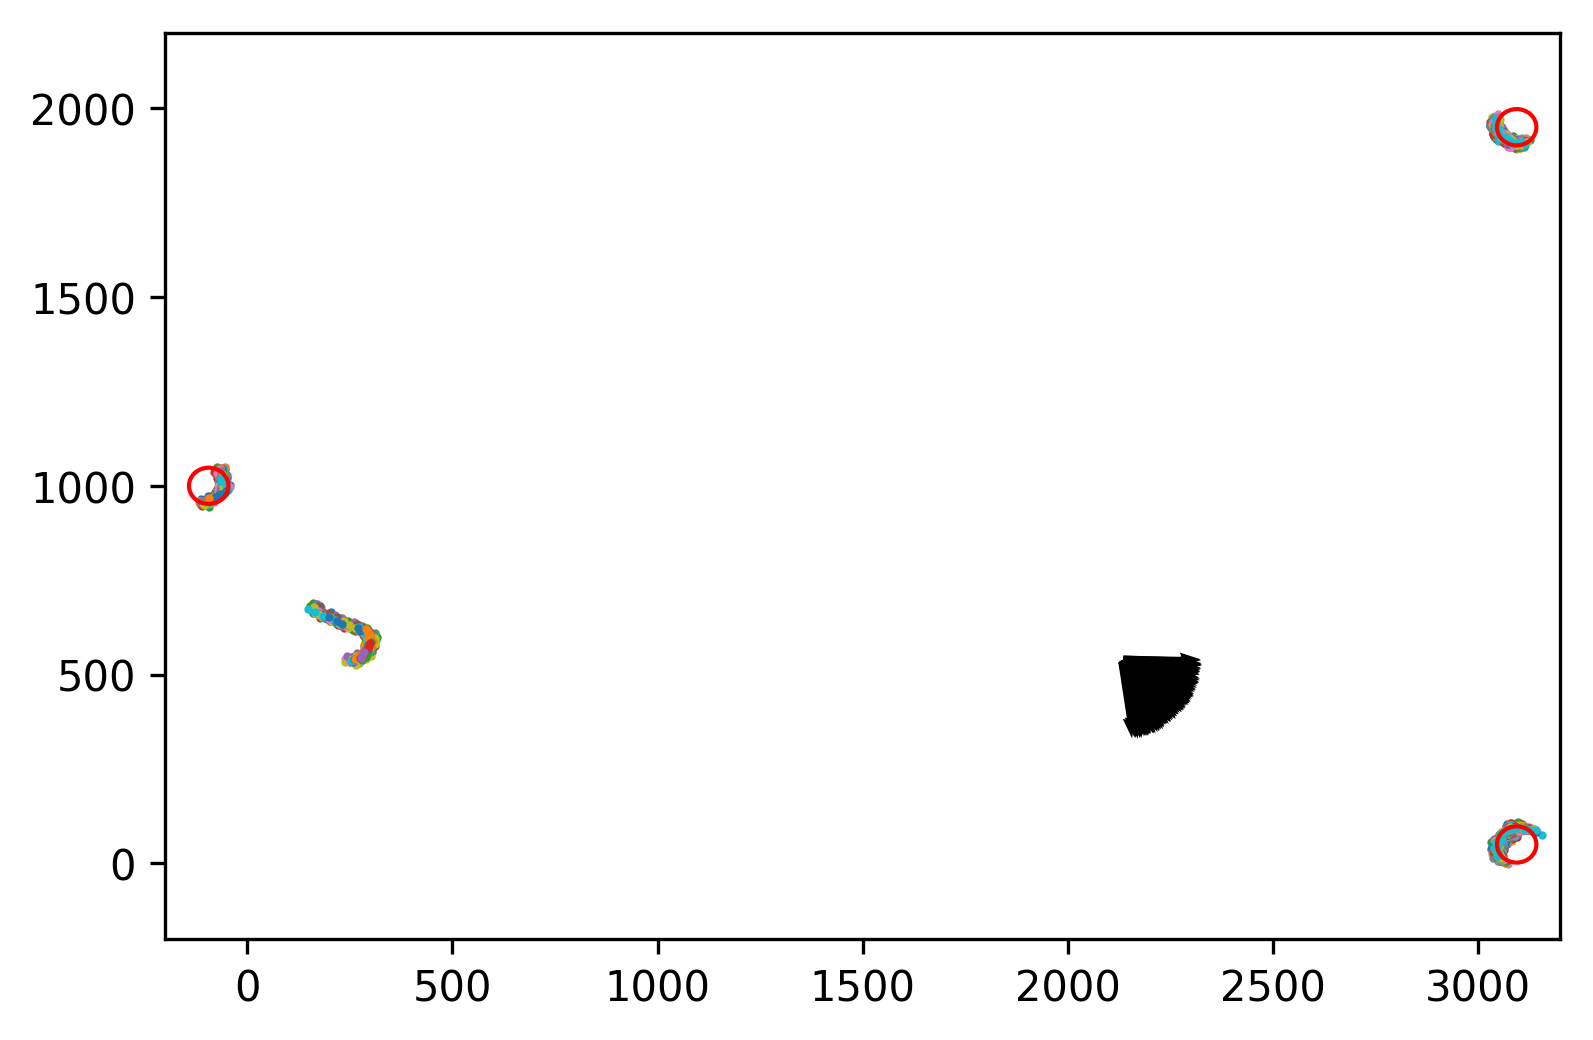

In [318]:
ind_start, ind_end = 60, 160
ps = pf_points[ind_start:ind_end]
ps1 = odom_lidar_points[ind_start:ind_end]
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)

for i in range(ind_start, ind_end):
    a, d = pf.get_landmarks(scans[i], pf.min_intens)
    x, y = pf.p_trans(a, d)
    points = np.zeros((len(x), 3))
    points[:, 0] = x
    points[:, 1] = y
    ax.scatter(*cvt_local2global(points, pf_points[i])[:, 0:2].T,  s=1)
    
for b in pf.beacons:
    ax.add_artist(plt.Circle(b, BEAC_R, linewidth=1, fill=False, color="r"))
    
ax.quiver(ps[:, 0], ps[:, 1], np.cos(ps[:, 2]), np.sin(ps[:, 2]), width=0.003)
plt.xlim(-200, 3200)
plt.ylim(-200, 2200)
# plt.xlim(3000, 3200)
# plt.ylim(1800, 2000)

## Particles

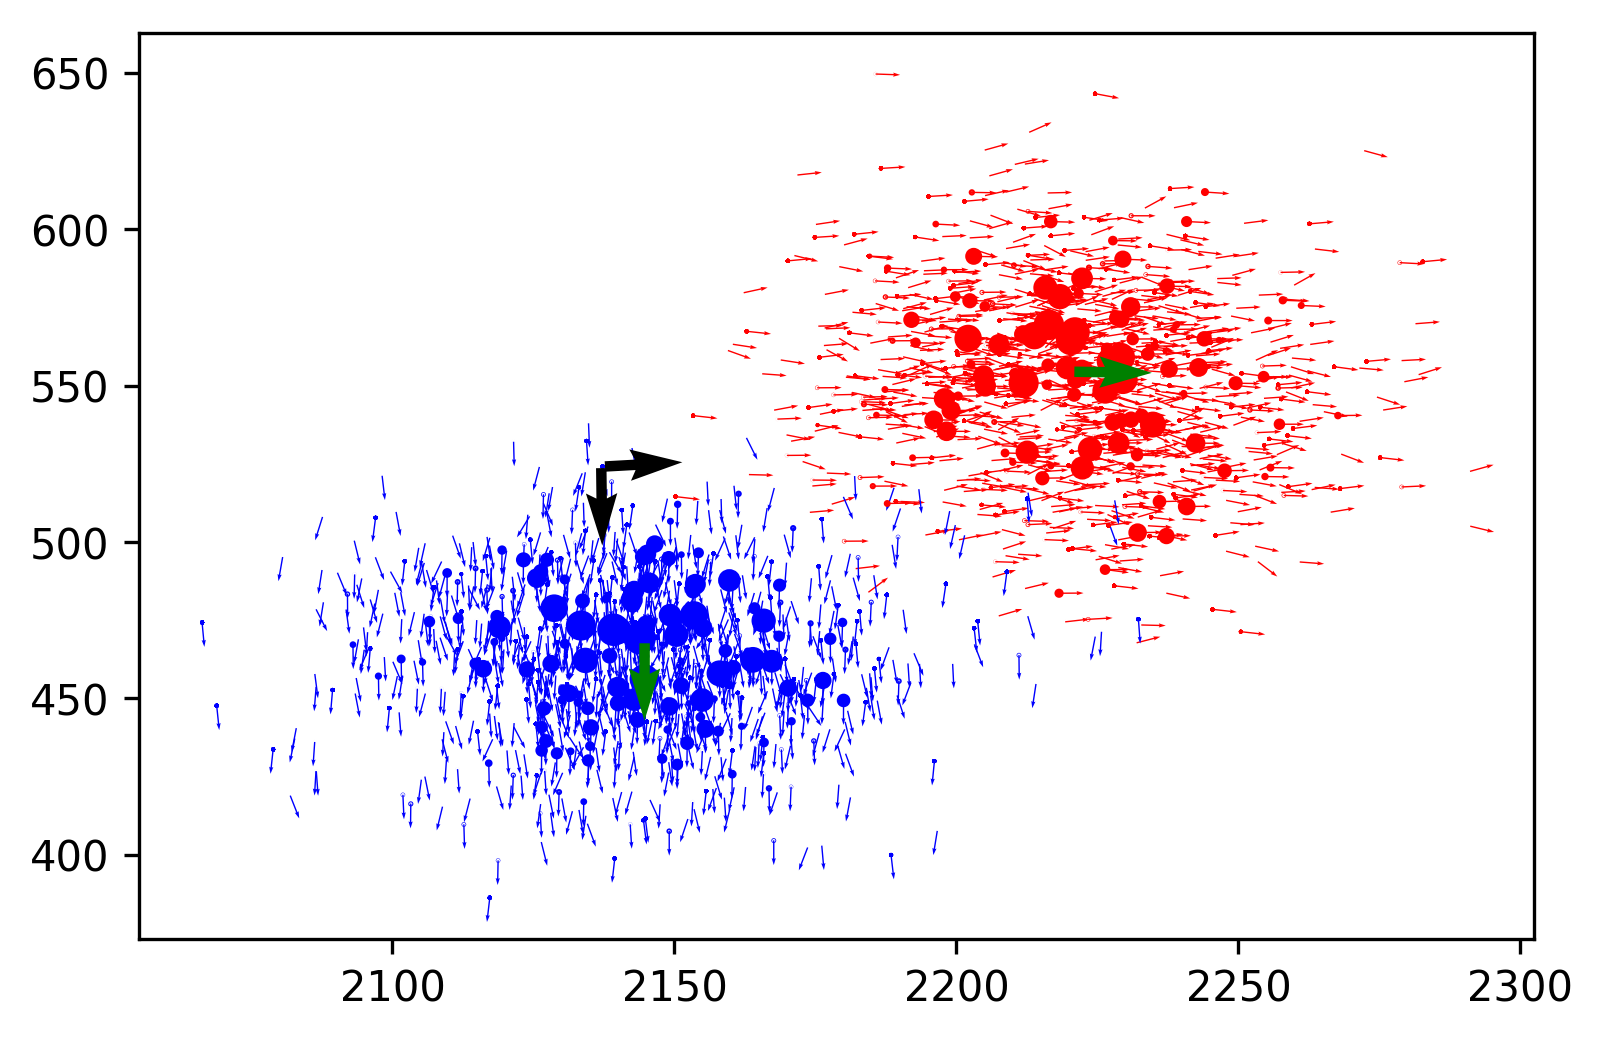

In [199]:
ind1 = 160
ind2 = 50
op1 = odom_lidar_points[ind1]
op2 = odom_lidar_points[ind2]
pf1 = pf_points[ind1]
pf2 = pf_points[ind2]
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
ps = all_particles1[ind1]
ps1 = all_particles1[ind2]
ax.quiver(ps[:, 0], ps[:, 1], np.cos(ps[:, 2]), np.sin(ps[:, 2]), width=0.001, color="red")
ax.quiver(ps1[:, 0], ps1[:, 1], np.cos(ps1[:, 2]), np.sin(ps1[:, 2]), width=0.001, color="blue")
ax.scatter(ps[:, 0], ps[:, 1], c="red", s=all_weights[ind1] * 1000)
ax.scatter(ps1[:, 0], ps1[:, 1], c="blue", s=all_weights[ind2] * 1000)
ax.quiver(op1[0], op1[1], np.cos(op1[2]), np.sin(op1[2]))
ax.quiver(op2[0], op2[1], np.cos(op2[2]), np.sin(op2[2]))
ax.quiver(pf1[0], pf1[1], np.cos(pf1[2]), np.sin(pf1[2]), color="green")
ax.quiver(pf2[0], pf2[1], np.cos(pf2[2]), np.sin(pf2[2]), color="green")
# plt.xlim(500, 1000)
# plt.ylim(500, 1500)
# plt.xlim(500, 1000)
# plt.ylim(500, 1500)

## The first particles

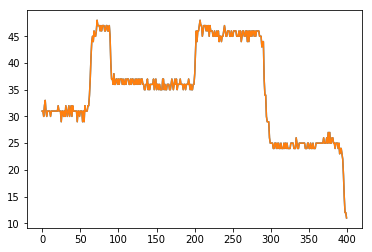

In [25]:
plt.plot([x["num_good_landmarks"] for x in best_particles_information][:])
plt.plot([x["num_good_landmarks"] for x in best_particles_information][:])

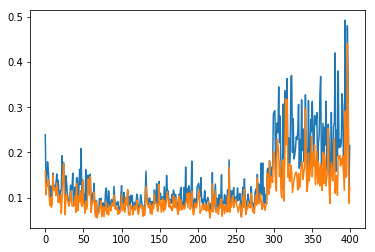

In [237]:
plt.plot([x["weights"][0] for x in best_particles_information][:])
plt.plot([x["weights"][1] for x in best_particles_information][:])

In [238]:
best_particles_information[308]

{'cost_function': array([2.13478679, 2.18579558, 2.21335609, 2.23195685, 2.27631898,
        2.36191815, 2.38137002, 2.42274767, 2.4268365 , 2.44499816]),
 'num_good_landmarks': 25,
 'particles': array([[2.13791943e+03, 5.25919862e+02, 2.10950947e+00],
        [2.13975022e+03, 5.22749272e+02, 2.10854034e+00],
        [2.13657718e+03, 5.29386974e+02, 2.10591837e+00],
        [2.14220996e+03, 5.29535426e+02, 2.10903456e+00],
        [2.13252306e+03, 5.30267509e+02, 2.10748199e+00],
        [2.14029369e+03, 5.30283174e+02, 2.10548898e+00],
        [2.14070408e+03, 5.20916236e+02, 2.11095706e+00],
        [2.13309337e+03, 5.30143182e+02, 2.11139590e+00],
        [2.13950000e+03, 5.33739858e+02, 2.11272992e+00],
        [2.13447465e+03, 5.34110268e+02, 2.10574946e+00]]),
 'weights': array([0.2802252 , 0.18033535, 0.14150464, 0.11993621, 0.08039618,
        0.0363396 , 0.03021615, 0.02030384, 0.01951439, 0.01634939])}

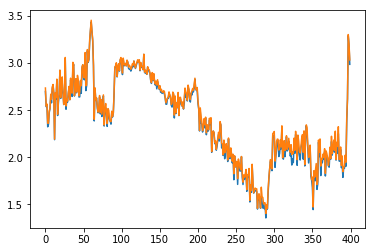

In [239]:
plt.plot([x["cost_function"][0] for x in best_particles_information][:])
plt.plot([x["cost_function"][1] for x in best_particles_information][:])

In [29]:
best_particles_information[307]["cost_function"][9]

2.270624360334559

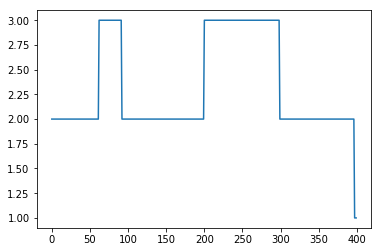

In [109]:
plt.plot(np.sum(all_is_beacon_seeing, axis=1))

# Look at many scans

In [70]:
def draw_pf_points(k, pf_points, true_pf_points):
    fig, ax = plt.subplots(3, 1, figsize=(8, 4), dpi=200, sharex=True)
    ax[0].set_title("Scan number %d"%k)
    for i in range(3):
        ax[i].plot(pf_points[:, i])
        ax[i].plot(true_pf_points[:, i])
    plt.show()
        
def operate_scan(k):
    scans = np.load("laser_scans%d.npy"%k)
    N = scans.shape[0]
    raw_odom_coords = np.load("odom_coords%d.npy"%k)
    raw_odom_coords[:, :2] *= 1000

    start_point = START_POINTS[k - 1]
    lidar_point = LIDAR_POINTS[k - 1]
    start_lidar_point = cvt_local2global(lidar_point, start_point)
    odom_diff = cvt_global2local(raw_odom_coords, raw_odom_coords[0])
    odom_robot_points = cvt_local2global(odom_diff, start_point)
    odom_lidar_points = cvt_local2global(lidar_point, odom_robot_points)
    
    delta_coords = cvt_global2local(odom_lidar_points, np.roll(odom_lidar_points, 1, axis=0))
    delta_coords[0] = np.array([0, 0, 0])
    delta_coords[-1] = np.array([0, 0, 0])
    
    pf = ParticleFilter(start_x=start_lidar_point[0], start_y=start_lidar_point[1], 
                    start_angle=start_lidar_point[2], **PF_PARAMS)
    pf_points = []
    for i in range(N):
        pf_points.append(pf.localisation(delta_coords[i], scans[i]))
    pf_points = np.array(pf_points)
    true_pf_points = np.load("pf_true_points%d.npy"%k)
    draw_pf_points(k, pf_points, true_pf_points)

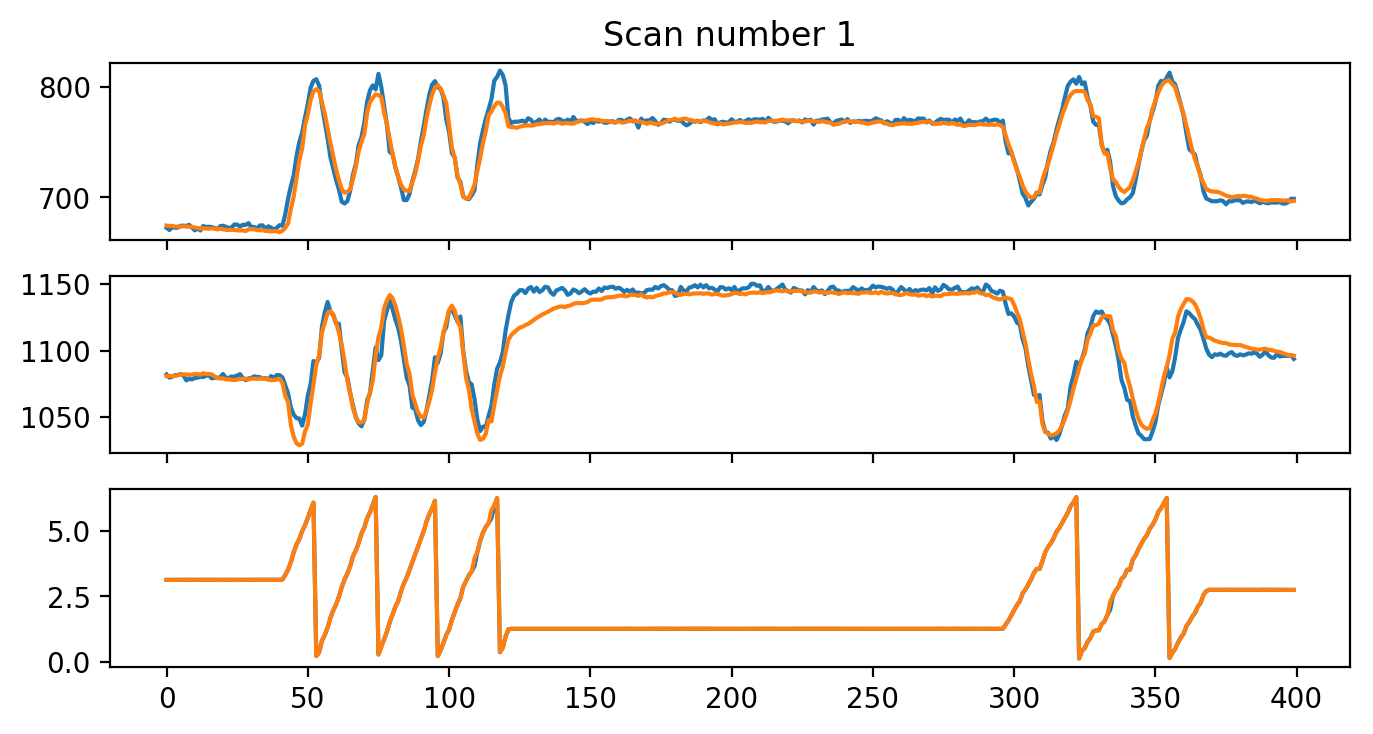

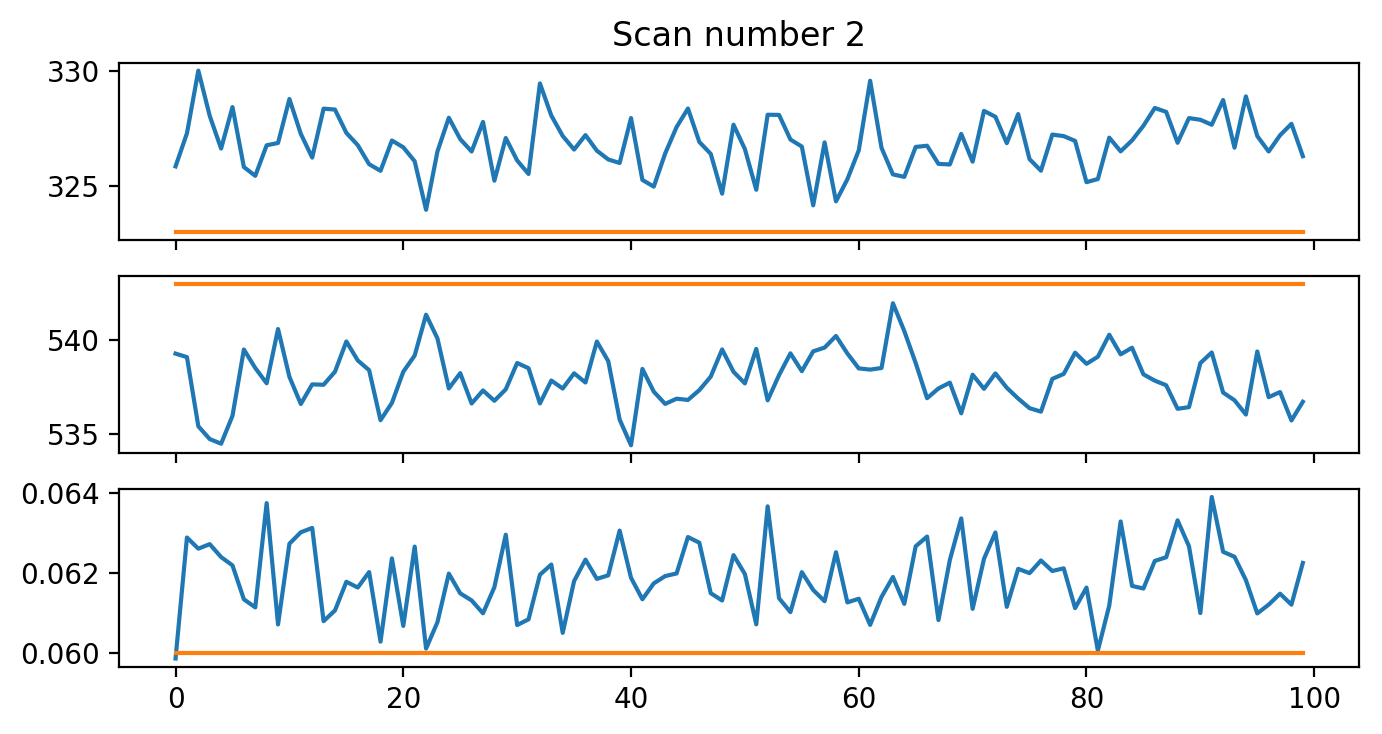

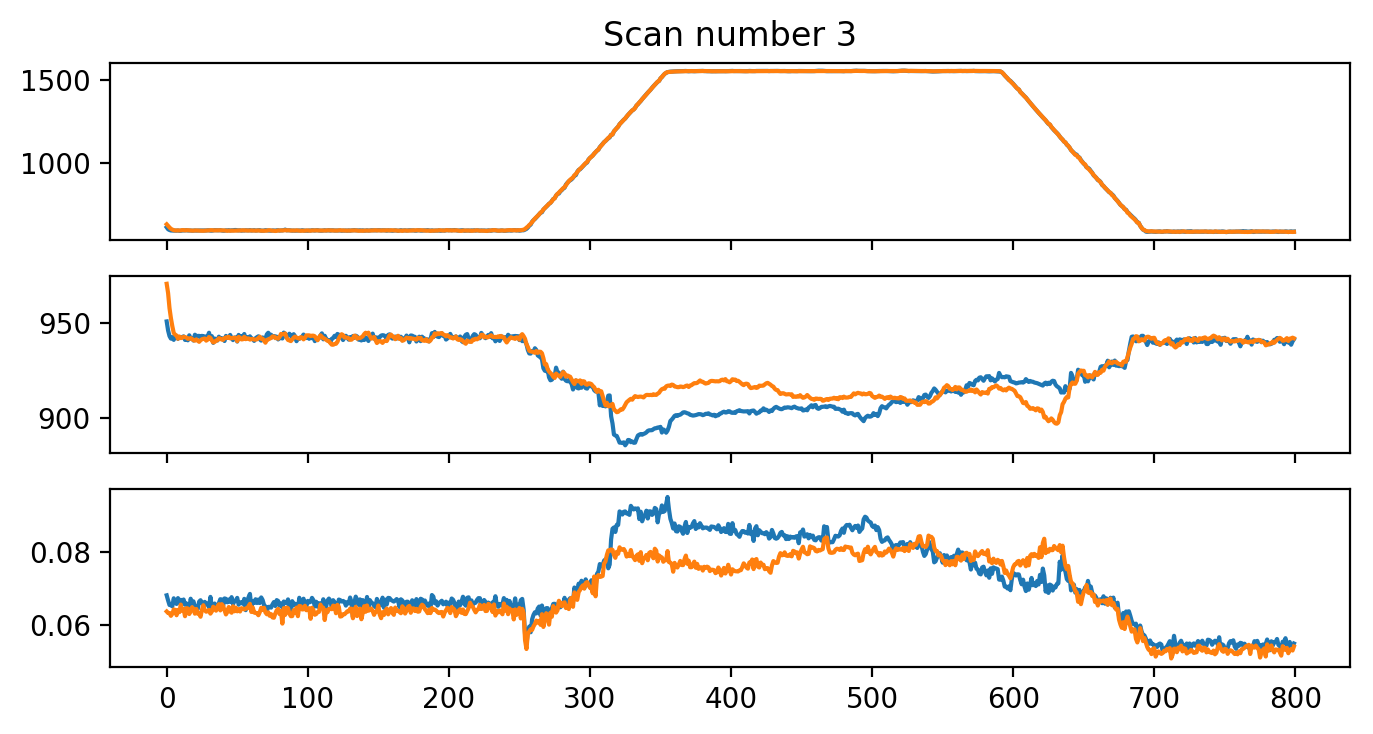

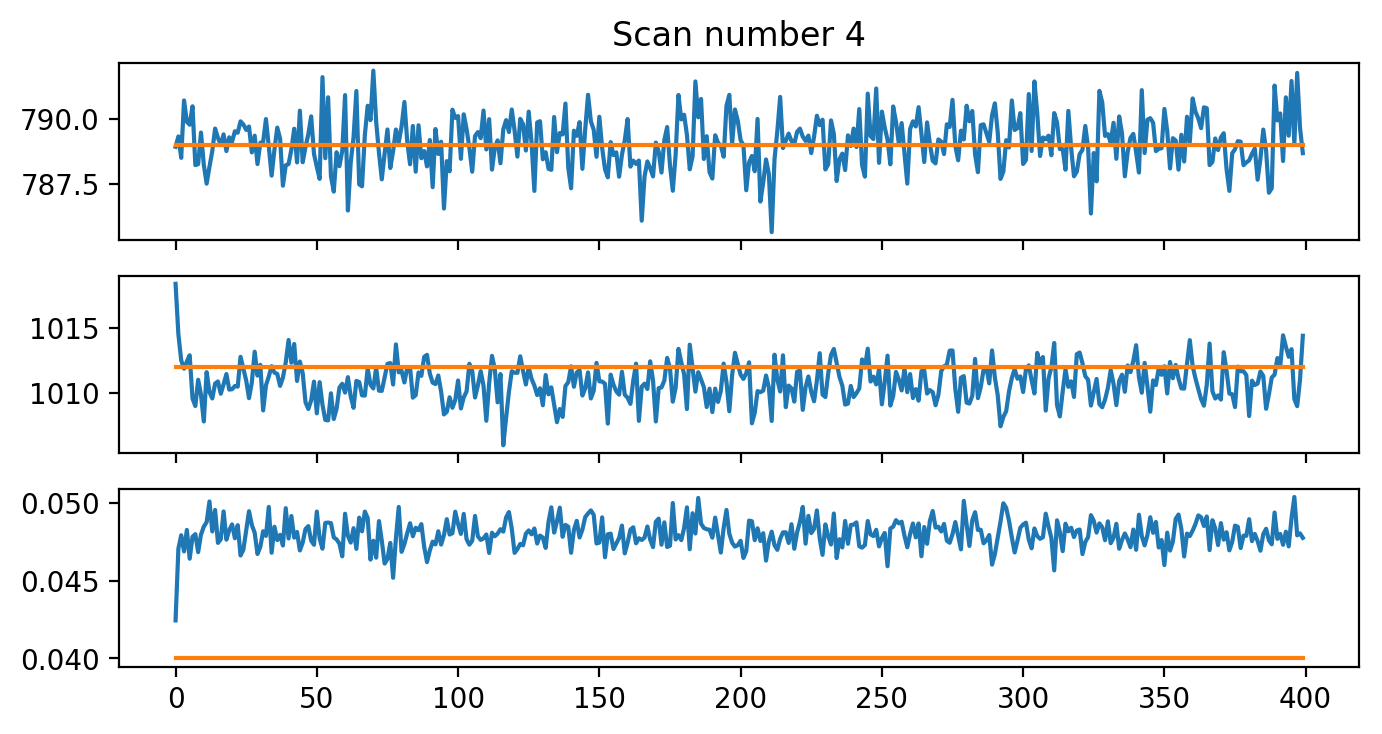

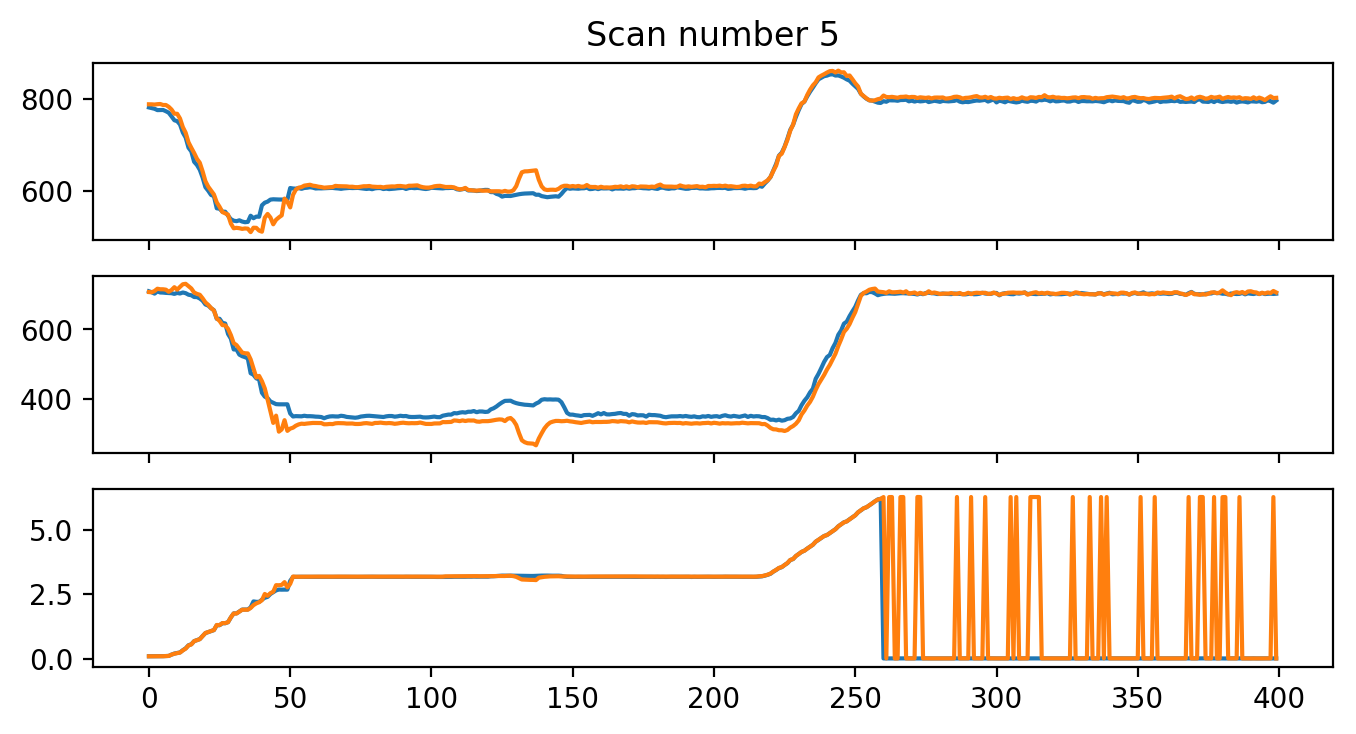

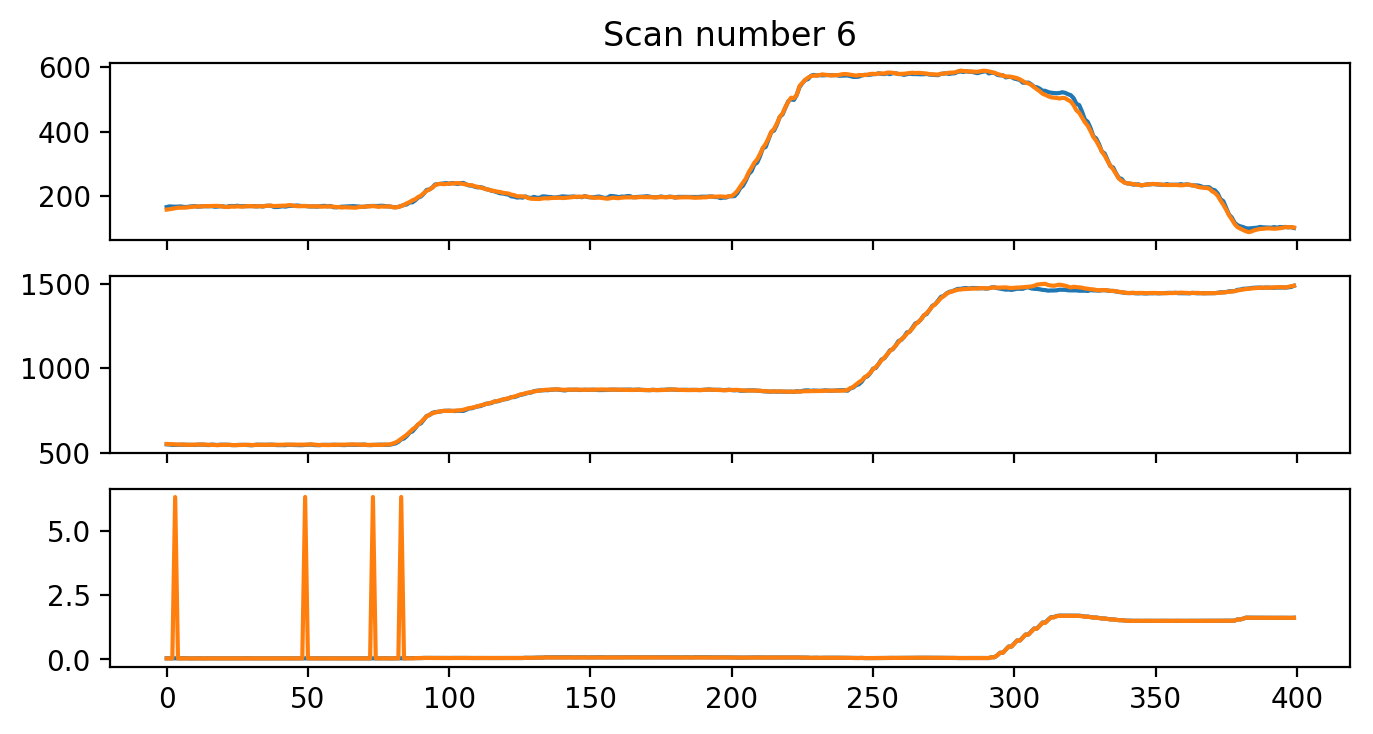

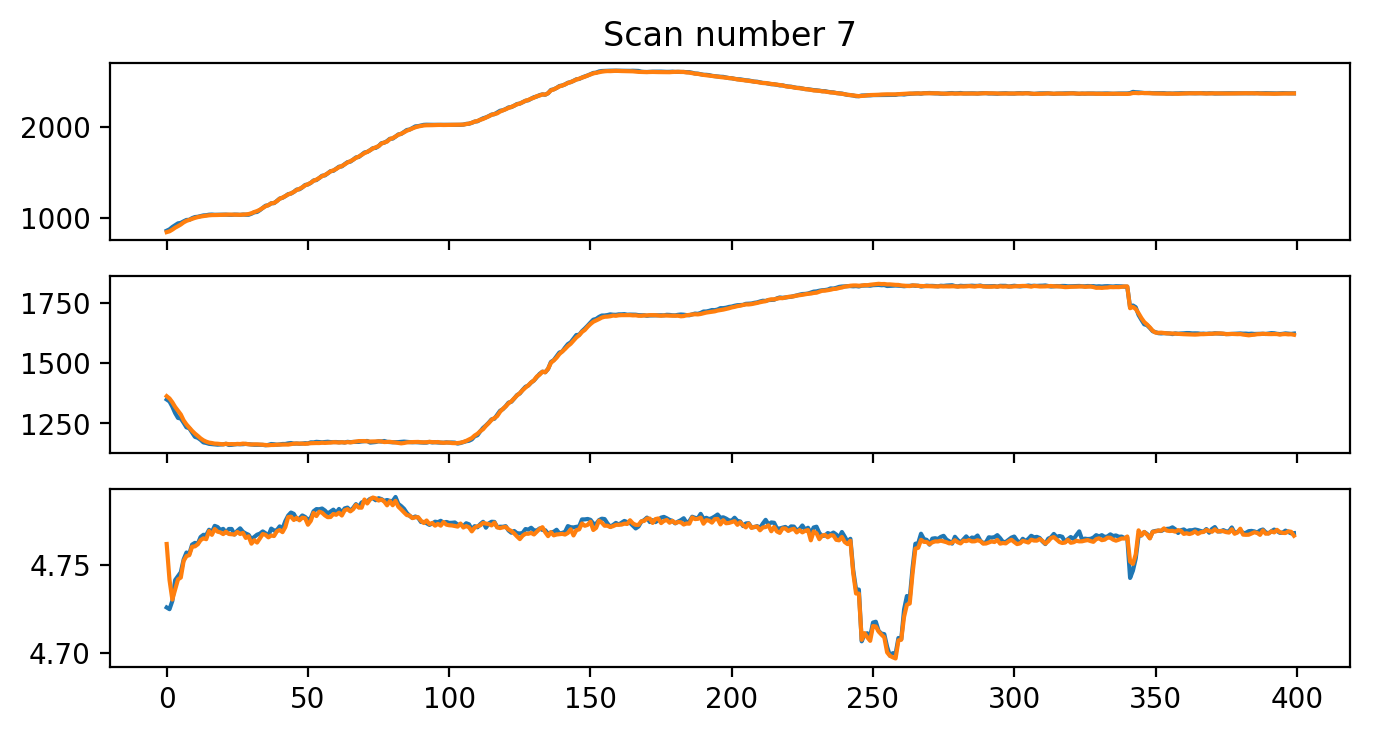

In [124]:
PF_PARAMS = {"particles_num": 1000,
             "sense_noise": 0.5,
             "distance_noise": 8,
             "angle_noise": 0.1,
             "min_intens": 3000,
             "max_dist": 3700,
             "k_angle": 120,
             "beac_dist_thresh": 150,
             "num_is_near_thresh": 0.1,
             "dist_offset": 0}

for i in range(1, 8):
    operate_scan(i)

# Find beacons

In [329]:
def fun(beacon, points):
    return np.sqrt((beacon[0] - points[:, 0]) ** 2 + (beacon[1] - points[:, 1]) ** 2) - BEAC_R

def find_beacon(points, init_beacon):
    return scipy.optimize.least_squares(fun, init_beacon, args=(points,), loss="linear")

def get_xy_scan_points(scan, sc_point):
    x, y = pf.p_trans(*pf.get_landmarks(scan, pf.min_intens))
    points = np.zeros((len(x), 3))
    points[:, 0] = x
    points[:, 1] = y
    points = cvt_local2global(points, sc_point)[:, 0:2]
    return points

def devide_points_beacons(points, beacons):
    beac_dist = np.sqrt((points[:, 0, np.newaxis] - beacons[np.newaxis, :, 0]) ** 2 +\
        (points[:, 1, np.newaxis] - beacons[np.newaxis, :, 1]) ** 2)
    points_ind = np.argmin(beac_dist, axis=1)
    min_beac_dist = np.min(beac_dist, axis=1)
    return points_ind, min_beac_dist

def get_new_beacons(old_beacons, points):
    beac_dist = np.sqrt((points[:, 0, np.newaxis] - old_beacons[np.newaxis, :, 0]) ** 2 +\
        (points[:, 1, np.newaxis] - old_beacons[np.newaxis, :, 1]) ** 2)
    points_ind = np.argmin(beac_dist, axis=1)
    min_beac_dist = np.min(beac_dist, axis=1)
    new_beacons = old_beacons.copy()
    seen_beacons = np.zeros(3, dtype=np.int32)
    for i in range(3):
        points_beac = points[(min_beac_dist < pf.beac_dist_thresh) * (points_ind == i)]
        if points_beac.shape[0] > 3:
            new_beacon = find_beacon(points_beac, pf.beacons[i].copy()).x
            new_beacons[i] = new_beacon
            seen_beacons[i] = 1
    return new_beacons, seen_beacons

def get_beacon_angles(beacons, points):
    dists = beacons - points[:, :2]
    angles = np.arctan2(dists[:, 1], dists[:, 0])
    return (points[:, 2] - angles) % (2 * np.pi)

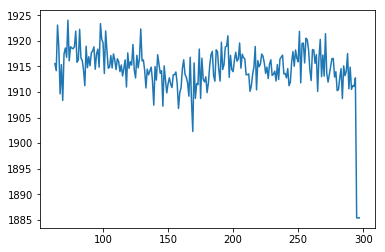

In [330]:
distances = []
old_distances = []
all_new_beacons = []
all_seen_beacons = []
for i in range(N):
    points = get_xy_scan_points(scans[i], pf_points[i])
    new_beacons, seen_beacons = get_new_beacons(pf.beacons, points)
    all_new_beacons.append(new_beacons)
    all_seen_beacons.append(seen_beacons)
    distances.append(np.linalg.norm(new_beacons[2] - new_beacons[1]))
    old_distances.append(np.linalg.norm(pf.beacons[2] - pf.beacons[1]))

all_seen_beacons = np.array(all_seen_beacons)
all_new_beacons = np.array(all_new_beacons)
distances = np.array(distances)
inds = ~np.logical_or(np.all(all_new_beacons[:, 1] == pf.beacons[1], axis=1),
                     np.all(all_new_beacons[:, 2] == pf.beacons[2], axis=1))

# distances[inds] = old_distances[0]
plt.plot(np.arange(N)[inds], distances[inds])
# plt.plot(old_distances)

In [341]:
test_points = pf_points.copy()
test_points[:, :2] = pf_points[0, :2]

(-100, 100)

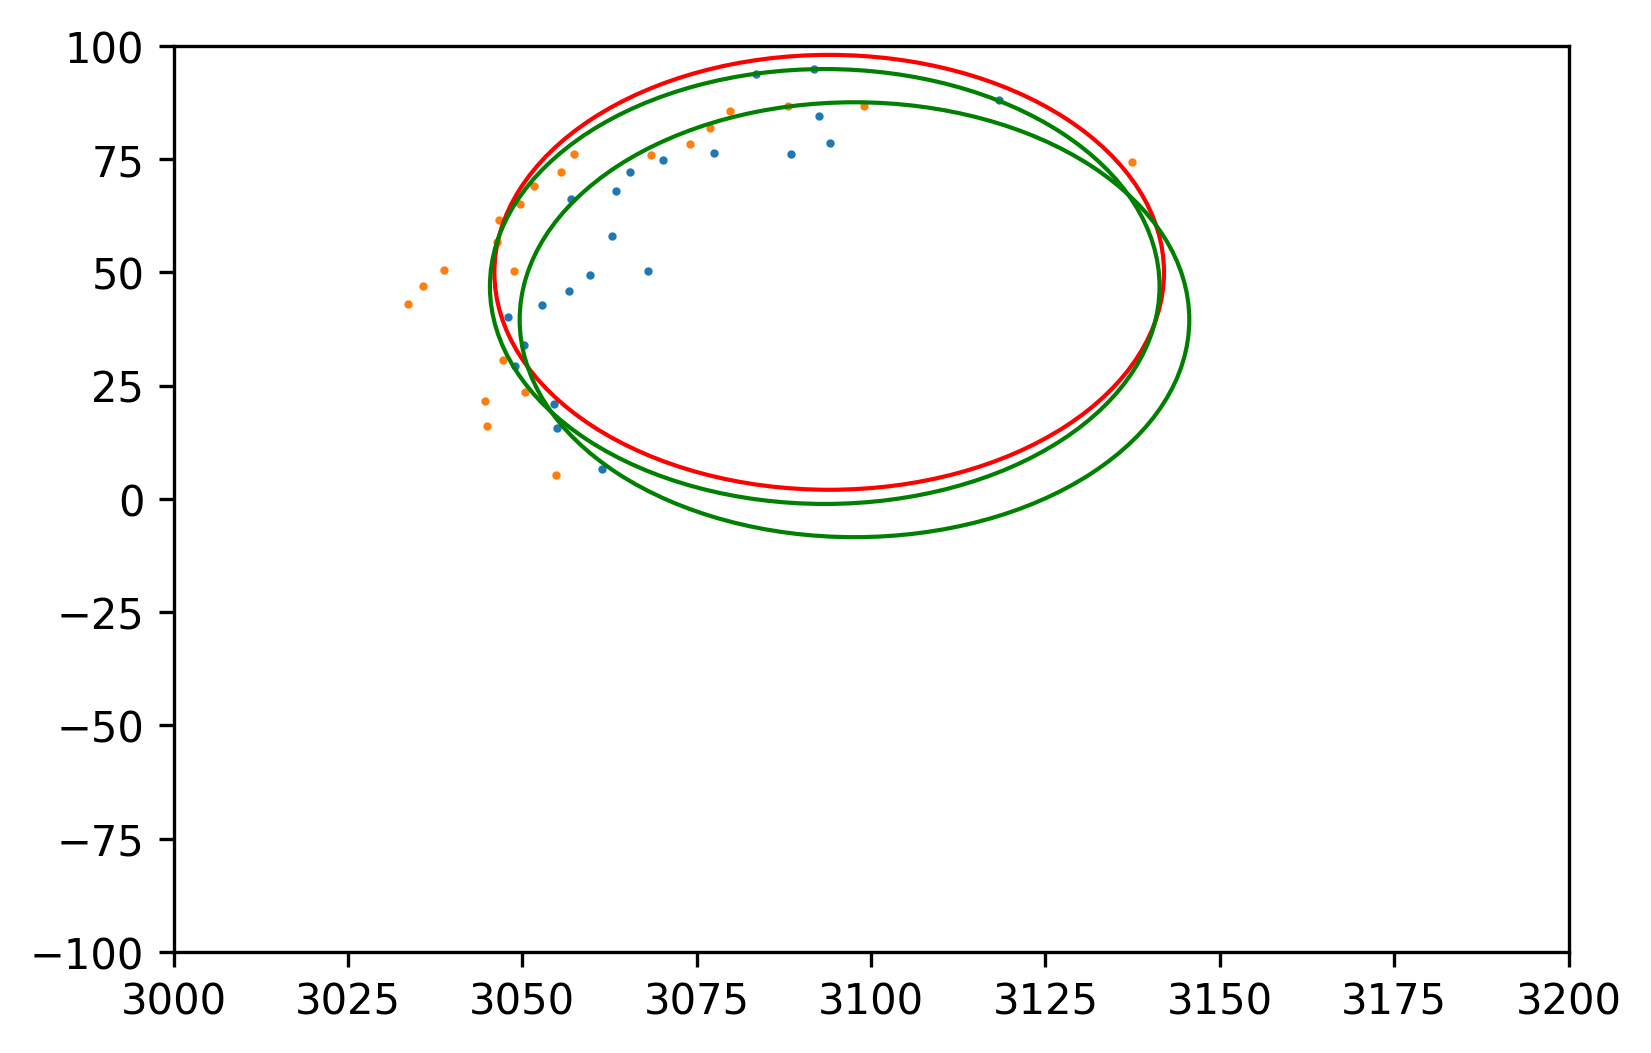

In [342]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
ind = 160
for i in [90, 150]:
    x, y = pf.p_trans(*pf.get_landmarks(scans[i], pf.min_intens))
    points = np.zeros((len(x), 3))
    points[:, 0] = x
    points[:, 1] = y
    ax.scatter(*cvt_local2global(points, test_points[i])[:, 0:2].T,  s=1)
    
for b in pf.beacons:
    ax.add_artist(plt.Circle(b, BEAC_R, linewidth=1, fill=False, color="r"))
for i in [90, 150]:
    for b in all_new_beacons[i]:
        ax.add_artist(plt.Circle(b, BEAC_R, linewidth=1, fill=False, color="g"))
# plt.xlim(-200, 3500)
# plt.ylim(-200, 2200)
plt.xlim(3000, 3200)
plt.ylim(-100, 100)

## Distances from robot

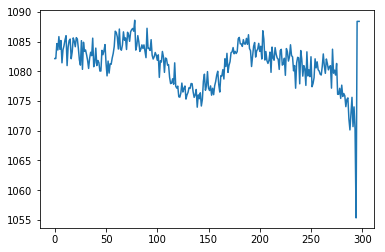

In [333]:
beacon_ind = 2
distances = np.linalg.norm(all_new_beacons[:, beacon_ind, :] - pf_points[:, :2], 
                               axis=1)[all_seen_beacons[:, beacon_ind] == 1]
plt.plot(np.arange(N)[all_seen_beacons[:, beacon_ind] == 1], distances)

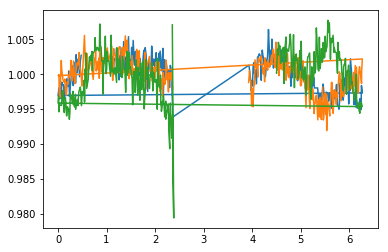

In [327]:
for beacon_ind in range(3):
    beacon_distances = np.linalg.norm(all_new_beacons[:, beacon_ind, :] - pf_points[:, :2], 
                               axis=1)[all_seen_beacons[:, beacon_ind] == 1]
    beacon_angles = get_beacon_angles(all_new_beacons[:, beacon_ind, :], pf_points)[all_seen_beacons[:, beacon_ind] == 1]
    plt.plot(beacon_angles, beacon_distances / np.mean(beacon_distances))

## Intensities

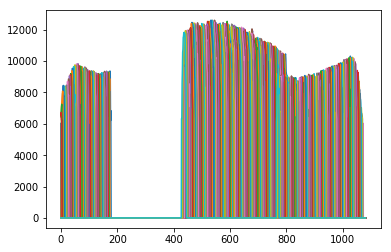

In [200]:
for i in range(50, 160):
    scan_ind = i
    intens = scans[scan_ind, :, 1]
    intens[scans[scan_ind, :, 1]< 6000] = 0
    plt.plot(intens)

In [347]:
beacon_intens = []
beacon_angles = []
beacon_distances = []
for i in range(N):
    scan_angles, scan_distances = pf.get_landmarks(scans[i], pf.min_intens)
    scan_intens = scans[i, scans[i, :, 1] > pf.min_intens, 1]
    
    a = all_new_beacons[i, :, :] - pf_points[i, np.newaxis, :2]
    beacon_angles1 = (np.arctan2(a[:, 1], a[:, 0]) - pf_points[i, np.newaxis, 2]) % (np.pi * 2)
    dangles = (beacon_angles1[:, np.newaxis] - scan_angles[np.newaxis, :]) % (np.pi * 2)
    dangles = np.where(dangles < np.pi, dangles, 2 * np.pi - dangles)
    
    beacon_angles.append(beacon_angles1)
    beacon_intens1 = np.zeros(3)
    beacon_distances1 = np.zeros(3)
    for j in range(3):
        if scan_intens[np.abs(dangles[j, :]) < 0.1].shape[0] > 0:
            beacon_intens1[j] = np.max(scan_intens[np.abs(dangles[j, :]) < 0.1])
            beacon_distances1[j] = scan_distances[np.argmax(scan_intens[np.abs(dangles[j, :]) < 0.1])]
    beacon_intens.append(beacon_intens1)
    beacon_distances.append(beacon_distances1)
beacon_intens = np.array(beacon_intens)
beacon_angles = np.array(beacon_angles)
beacon_distances = np.array(beacon_distances)

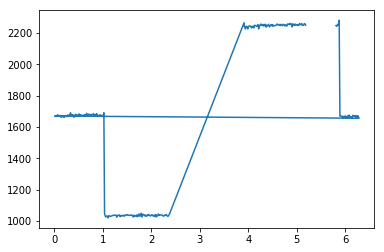

In [352]:
for j in range(1):
    distances = beacon_distances[:, j][beacon_intens[:, j] != 0]
    plt.plot(beacon_angles[:, j][beacon_distances[:, j] != 0], distances)

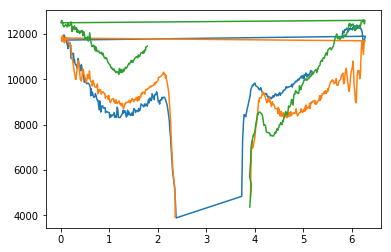

In [114]:
for j in range(3):
    plt.plot(beacon_angles[:, j][beacon_intens[:, j] != 0], beacon_intens[:, j][beacon_intens[:, j] != 0])

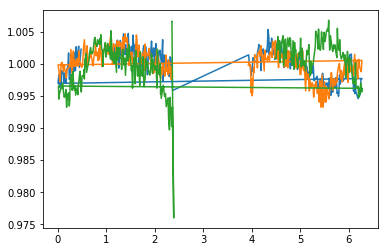

In [116]:
for beacon_ind in range(3):
    beacon_distances = np.linalg.norm(all_new_beacons[:, beacon_ind, :] - pf_points[:, :2], 
                               axis=1)[all_seen_beacons[:, beacon_ind] == 1]
    beacon_angles = get_beacon_angles(all_new_beacons[:, beacon_ind, :], pf_points)[all_seen_beacons[:, beacon_ind] == 1]
    plt.plot(beacon_angles, beacon_distances / np.mean(beacon_distances))

In [63]:
np.abs(dangles) > 0.5

array([[False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [ True,  True, False],
       [ True,  True, False],
       [ True,  True, False],
       [ True,  True, False],
       [ True,  True, False],
       [ T

# Trianglulation

In [258]:
def fun_1(X, points, num_beacons):
    beacons = pf.beacons[num_beacons]
    points = cvt_local2global(points, X)[:, 0:2]
    r = np.sum((beacons - points) ** 2, axis=1) ** 0.5 - BEAC_R
    return r

In [263]:
ind = 160
x, y = pf.p_trans(*pf.get_landmarks(scans[ind], pf.min_intens))
points = np.zeros((len(x), 3))
points[:, 0] = x
points[:, 1] = y

init_X = pf_points[ind].copy()
apr_points = get_xy_scan_points(scans[ind], init_X)
beacons_len = np.sum((pf.beacons[np.newaxis, :, :] - apr_points[:, np.newaxis, :]
                     ) ** 2, axis=2) ** 0.5
points = points[np.min(beacons_len, axis=1) < pf.beac_dist_thresh]
num_beacons = np.argmin(beacons_len[np.min(beacons_len, axis=1) < pf.beac_dist_thresh], axis=1)

In [268]:
res = scipy.optimize.least_squares(fun_1, init_X,
                                   args=[points, num_beacons], ftol=1e-3)
tr_point = res.x
tr_point

array([2135.29638423,  539.82984505,    6.27343678])

In [265]:
np.sqrt(np.sum(fun_1(init_X, points, num_beacons).round() ** 2))

31.796226191169293

In [266]:
np.sqrt(np.sum(fun_1(tr_point, points, num_beacons).round() ** 2))

30.04995840263344

(-200, 2200)

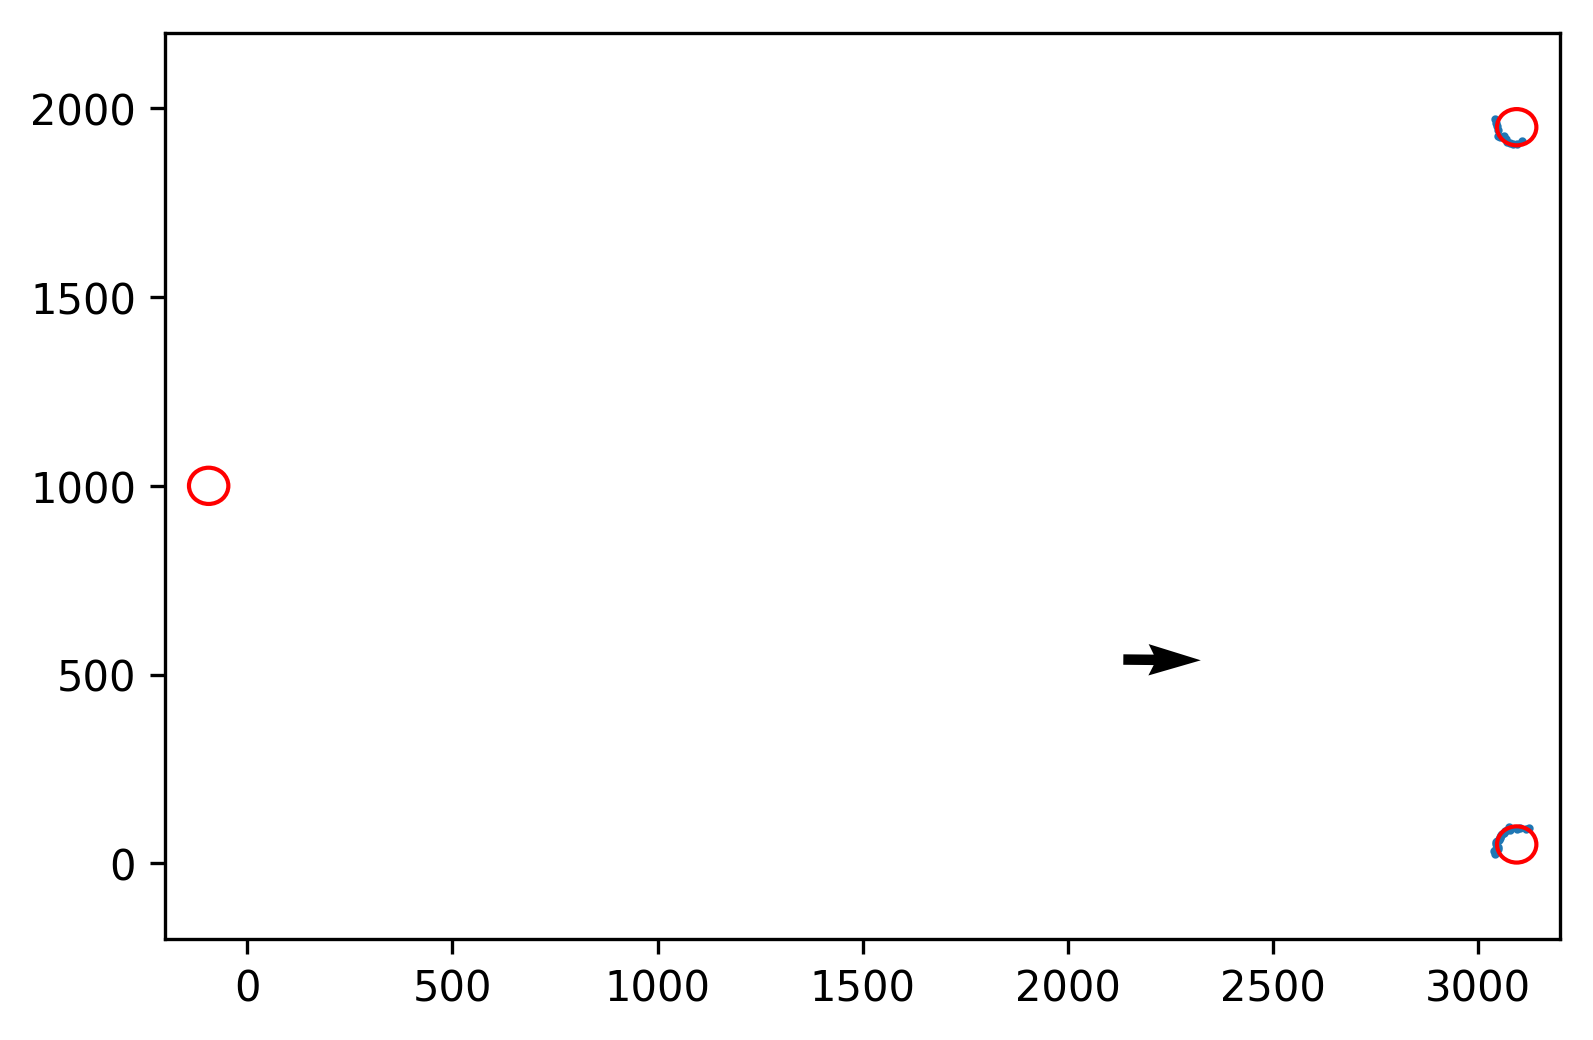

In [267]:
ind_start, ind_end = 160, 161
ps = np.array([tr_point])
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
# init_X = np.array([770, 1150, 1.26])
for i in range(ind_start, ind_end):
    x, y = pf.p_trans(*pf.get_landmarks(scans[i], pf.min_intens))
    points = np.zeros((len(x), 3))
    points[:, 0] = x
    points[:, 1] = y
    ax.scatter(*cvt_local2global(points, tr_point)[:, 0:2].T,  s=1)
    
for b in pf.beacons:
    ax.add_artist(plt.Circle(b, BEAC_R, linewidth=1, fill=False, color="r"))
    
ax.quiver(ps[:, 0], ps[:, 1], np.cos(ps[:, 2]), np.sin(ps[:, 2]))
plt.xlim(-200, 3200)
plt.ylim(-200, 2200)

In [707]:
tr_point

array([605.74504712, 353.86290896,   3.18059852])

In [708]:
init_X

array([612.39469032, 337.31536983,   3.19436621])

In [65]:
from multiprocessing import Pool
pool = Pool()

/usr/lib/python3.5/multiprocessing/pool.py:44: RuntimeWarning: overflow encountered in exp
  return list(map(*args))
/usr/lib/python3.5/multiprocessing/pool.py:44: RuntimeWarning: overflow encountered in exp
  return list(map(*args))
/usr/lib/python3.5/multiprocessing/pool.py:44: RuntimeWarning: overflow encountered in exp
  return list(map(*args))
/usr/lib/python3.5/multiprocessing/pool.py:44: RuntimeWarning: overflow encountered in exp
  return list(map(*args))
